# REAL OPTIONS VALUATION
## Binomial pricing model

We are going to study the usage of a binomial option pricing model to value real options. For this, we will use an Excel financial model of a fictional soybean processing plant. Our financial model is intentionally oversimplified, so we can concentrate on the actual implementation of ROA methods rather than wasting time on developing a fully fledged DCF valuation tool. Also, for simplicity, we will assume that the only option embedded into our project is the abandonment option - the right to stop the project and, possibly, to realise its salvage value. It is similar to the American put option in the financial derivatives world. We’ll assume that our option can be exercised after the investment stage for the salvage value of its capital assets.

In financial mathematics, a binomial lattice can be used to value European and American options. The lattice shows how an asset price, for instance, a stock price, is evolving over time. The binomial lattice can only move up (u) or down (d) in each time step.

<img src="binomialtree.png" width="350">

Assuming that the asset price is governed by a **geometric Brownian motion**, these movements can be calculated as:

$$ u = {e}^{\sigma\sqrt{\Delta t}} $$
$$ d = \frac{1}{u} $$

The lattice is solved by backward induction. First, at the terminal node, the value of the (put) option is calculated:

$$ \max(K-S, 0)$$

where $S$ is the asset value and $K$ is the strike price of the option.

At each earlier node the expected continuation value is calculated as:

$$ V = [p\times V_u + (1-p)\times V_d]\times dr$$

where the risk-neutral probability of the up movement is given by $ p = \frac{e^{r\Delta t}-d}{u-d} $.

The estimated continuation value is compared to the early exercise value, and the largest number is chosen.

[This](https://github.com/bdmitry09/Real-Options/blob/master/ROV-1/BinomialLattice.ipynb) short code snippet replicates one example from "Options, futures, and other derivatives" by John Hull.

To value the real option by the binomial lattice, we will follow the approach proposed by Copeland & Antikarov and later used by Mun, Herath and Park and many other researchers, the so called “marketed asset disclaimer”. This approach is based on the idea that an investment with real options should be valued as if it was a traded asset. Then the best estimate of the market value of the project is the present value of the project itself, without flexibility. Copeland & Antikarov approach uses a Monte Carlo simulation on the project’s present value to develop a hypothetical distribution of one-period returns. On each simulation run, the value of the future cash flows is estimated at two time periods, one for the first time period and another for the present time. The cash flows are discounted and summed to the time 0 (PV0) and 1 (PV1), and their logarithmic ratio is calculated. Volatility $\sigma$ is defined as the standard deviation of this ratio. Some researchers argue that to get a better volatility estimate, we need to simulate only PV1, while PV0 should be held constant.

For now, we will assume that the only source of uncertainty in our project is the soybean price. To make things even simpler, we assume that no corrections should be made to employ a risk-neutral valuation.

First, we will collect the data on soybeans historical prices from IndexMundi and visualize it using <code>matplotlib</code> library.


In [1]:
import os
from warnings import filterwarnings
from ipywidgets import interact, fixed

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler
from tqdm import tqdm
from graphviz import Graph

import xlwings as xw

from rpy2.robjects import pandas2ri

filterwarnings('ignore')
pandas2ri.activate()


In [3]:
#Plots styling
figure = {'figsize': (16, 6),
          'facecolor': '#f9f9f9',
          'subplot.wspace': 0.1,
          'dpi': 120}

colors = ["#ab5787",
          "#51b2e5",
          "#703c5c",
          "#168dd9",
          "#d190b6",
          "#00609f",
          "#d365ba",
          "#154866",
          "#666666",
          "#c4c4c4"]

axes = {'grid': True,
        'spines.left': False,
        'spines.right': False,
        'spines.top': False,
        'spines.bottom': False,
        'grid.axis': 'y',
        'facecolor': '#f9f9f9',
        'edgecolor': '#f9f9f9',
        'autolimit_mode': 'round_numbers',
        'xmargin': 0,
        'prop_cycle': cycler('color', colors)}

grid = {'color': '#979797', 'linewidth': 0.2}

tick = {'color': '#979797', 'major.size': 0, 'minor.size': 0}

plt.rc('figure', **figure)
plt.rc('axes', **axes)
plt.rc('grid', **grid)
plt.rc(('xtick', 'ytick'), **tick)


In [4]:
link = 'https://www.indexmundi.com/commodities/?commodity=soybeans&months=360'

df = pd.DataFrame()

if not os.path.exists('soybean_prices.csv'):
    df = (pd.read_html(link,
                       attrs={'class': 'tblData'},
                       header=0, parse_dates=['Month'])[0]
          .drop('Change', axis=1)
          .to_csv('soybean_prices.csv'))

df = (pd.read_csv('soybean_prices.csv', parse_dates=['Month'])
      .drop(columns={'Unnamed: 0'})
      .rename(str.lower, axis='columns')
      .rename(columns={'price': 'soybeans'})
      .set_index('month'))
df.head()


,soybeans
month,
1989-05-01,297.0
1989-06-01,291.0
1989-07-01,272.0
1989-08-01,236.0
1989-09-01,237.0


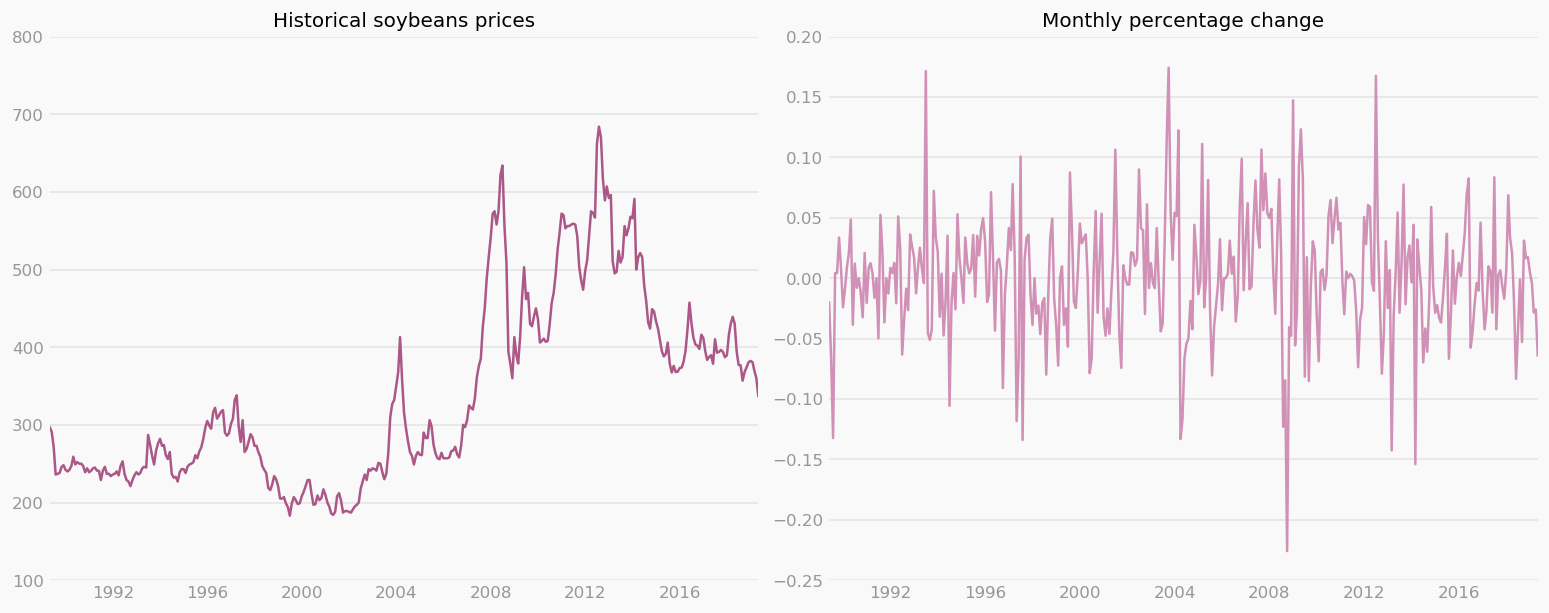

In [5]:
plt.subplot(121)
plt.plot(df)
plt.title('Historical soybeans prices')

plt.subplot(122)
plt.plot(df.pct_change().dropna(), color='#d190b6')
plt.title('Monthly percentage change');

We will fit the geometric Brownian motion to this data, which is usually a good starting point to model commodity prices. A stochastic process $S_t$ is said to follow a GBM if it satisfies the following stochastic differential equation (SDE):

$$\mathrm{d}S_t = \mu S_t\mathrm{d}t + \sigma S_t\mathrm{d}W$$

where $W_{t}$ is a Wiener, process $\mu$  ('the drift') and $\sigma$ ('the volatility') are the parameters to estimate.

It's pretty straightforward to fit and simulate the GBM with the Python scientific stack, but we will use the <code>YUIMA</code> package from R to do all the dirty work for us.

In [6]:
%load_ext rpy2.ipython

In [7]:
%%R -i df -o coefs
require('yuima')
set.seed(0)

df <- data.frame(df)

gbm <- setModel(drift="mu*x", diffusion="sigma*x")

model <- setYuima(data=setData(df, delta=1/12), model=gbm)

fit <- qmle(model, start=list(mu=0.01, sigma=0.1),
            lower=list(mu=0.001, sigma=0.001),
            upper=list(mu=1, sigma=1))

result <- summary(fit)@coef

coefs <- data.frame(rownames(result), result)


In [8]:
(coefs.rename(columns={'rownames.result.': 'Coefficients'})
 .set_index('Coefficients'))


,Estimate,Std..Error
Coefficients,,
sigma,0.173384,0.006450
mu,0.019389,0.031655


The diffusion parameter is estimated with a fairly high precision, but the drift is estimated rather poorly. Let’s try estimating the model without the drift.

In [9]:
%%R -o aic_ret

gbm_1 <- setModel(drift="mu*x", diffusion="sigma*x")

model1 <- setYuima(data=setData(df, delta=1/12), model=gbm_1)

fit1 <- qmle(model, start=list(mu=0.01, sigma=0.1),
             lower=list(mu=0.01, sigma=0.01),
             upper=list(mu=1, sigma=10))

gbm_2 <- setModel(drift=0, diffusion="sigma*x")

model2 <- setYuima(data=setData(df, delta=1/12), model=gbm_2)

fit2 <- qmle(model2, start=list(sigma=0.1),
             lower=list(sigma=0.01),
             upper=list(sigma=10))

aic_ret <- AIC(fit1, fit2)


In [10]:
aic_ret


,df,AIC
0,2.0,3017.716435
1,1.0,3016.091404


The model without the drift looks slightly better. Let's simulate and visualize one path from this stochastic process.

In [11]:
%%R -o sim
set.seed(0)
X <- simulate(gbm_2, true.parameter=fit2@coef, delta=1/12, xinit=df[length(df[, 1]),])
sim <- data.frame('prices_soybean'=get.zoo.data(X)[[1]])


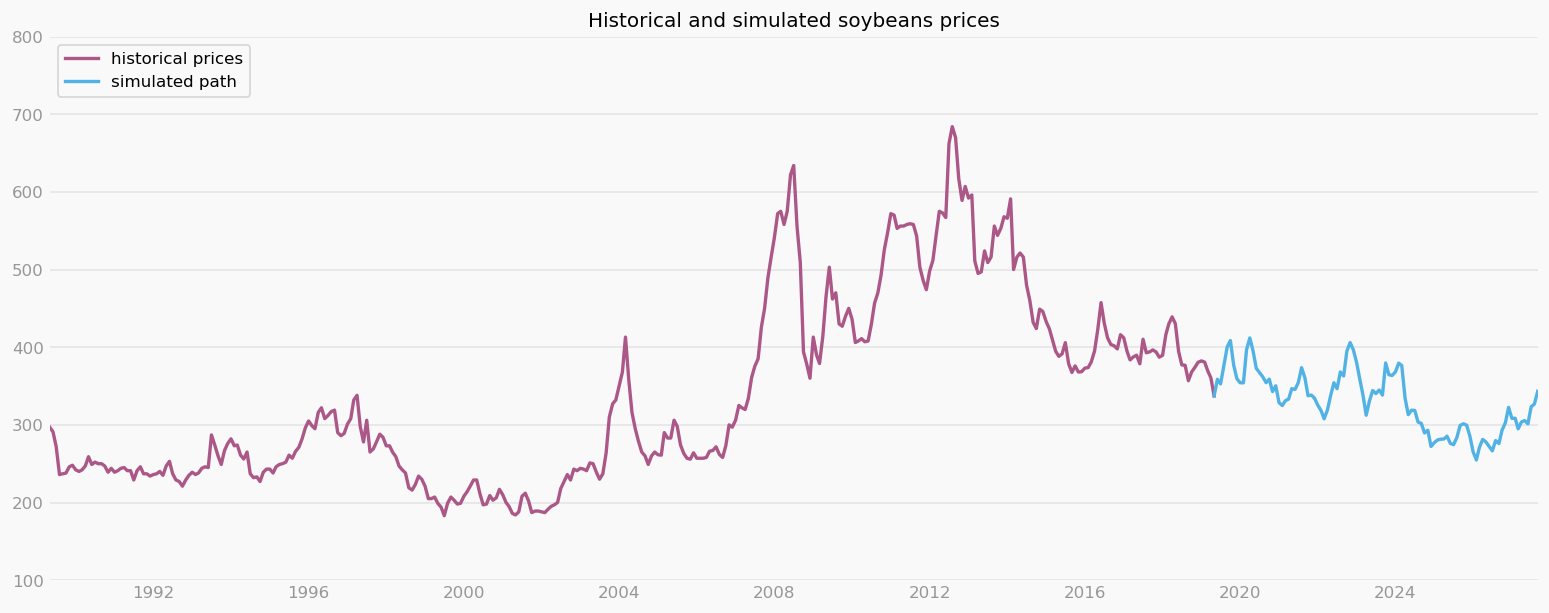

In [12]:
ind_last = df.index[-1]

start = pd.Timestamp(ind_last)
end = pd.Timestamp(start + pd.DateOffset(months=101))

dt_index = pd.DatetimeIndex(freq='MS', start=ind_last, periods=101)
df_simulation = df[['soybeans']]
df_simulation = df_simulation.reindex(df.index.union(dt_index))
df_simulation['soybeans_simulated'] = sim.set_index(dt_index)

plt.plot(df_simulation, linewidth=2)

plt.legend(['historical prices', 'simulated path'], loc='upper left')
plt.title('Historical and simulated soybeans prices');


Now we are ready to perform the Monte Carlo simulation of the soybeans prices. We will simulate the GBM in R and plug the results into the financial model in Excel using <code>xlwings</code>.

In [13]:
%%R
set.seed(seed=0)

coef = fit2@coef

simulate_gbm <- function (time=9) {
    samp <- setSampling(Initial=1, delta=1, n=time)
    
    X <- simulate(gbm_2, sampling=samp, true.parameter=coef,
                  xinit=df[length(df[,1]),])
  
    return(as.list(data.frame(get.zoo.data(X))))}

In [14]:
n_sims = 1000

wb = xw.Book('ROV_model_1.xlsx')
sht = wb.sheets['Calculations_s']
wb = xw.Book('ROV_model_1.xlsx')
PV0_d = sht.range('PV0_d').value

log_PV = np.zeros(n_sims)
PV_s = np.zeros(n_sims)

sht_inputs = wb.sheets['Inputs']
dr, t = sht_inputs.range('assum').value
t = int(t)

soybean_prices = np.zeros((n_sims, t-1))

K = np.array(sht.range('strike').value)
temp = sht.range('sim_inp').value

sht_inputs.range('date').value = ind_last
sht_inputs.range('prices').value = df.iloc[-1, :].values

for i in tqdm(range(n_sims)):
    X = %R -i t simulate_gbm(time=t-1)
    soybean_prices[i] = np.array(X)[:, 1:]

for i in tqdm(range(n_sims)):
    sim_out = soybean_prices[i]
    sht.range('sim_inp').value = sim_out
    log_PV[i] = sht.range('sim_out').value
    PV_s[i] = sht.range('PV0_s').value

sht.range('sim_inp').value = temp
#wb.close()

100%|██████████| 1000/1000 [00:38<00:00, 25.67it/s]


In [15]:
print ('The volatility estimate is {:.2f}'.format(log_PV[~np.isnan(log_PV)].std(ddof=1)))

The volatility estimate is 0.44


Now we will solve for the option value and visualize the lattice using <code>graphviz</code>.

In [16]:
dis_f = 1 / (1 + dr)
σ = log_PV[~np.isnan(log_PV)].std(ddof=1)
up = np.exp(σ)
down = 1 / up
p = ((1+dr) - down) / (up - down)
mu = np.resize(np.arange(t), (t, t))
md = mu.T
mu = up ** (mu - md)
md = down ** md
S = PV0_d * mu * md
S = np.triu(S)
V = np.zeros_like(S)
D = np.full((t, t), '', dtype='object_')
V[:, -1] = np.where(K[-1] - S[:, -1] > 0, K[-1] - S[:, -1], 0)
D[:, -1] = np.where(K[-1] - S[:, -1] > 0, 'abandon', 'continue')

for tp in range(t-2, -1, -1):
    V[:, tp] = (V[:, tp + 1] * p + np.roll(V[:, tp + 1],
                                           shift=-1, axis=0) * (1 - p)) * dis_f
    D[:, tp] = np.where(K[tp] - S[:, tp] > V[:, tp], 'abandon', 'continue')
    V[:, tp] = np.where(K[tp] - S[:, tp] > V[:, tp], K[tp] - S[:, tp], V[:, tp])


option_value = V[0,0]
print('Option value is', option_value.astype(int))


Option value is 1289


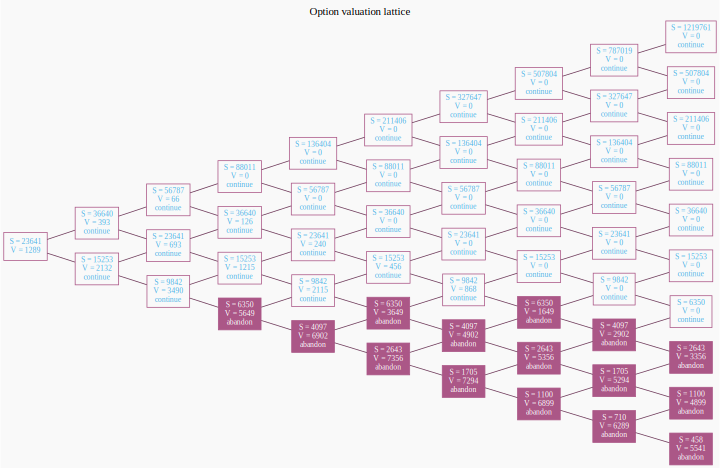

In [34]:
dot = Graph(name='Option valuation lattice')
dot.attr(label='Option valuation lattice', size='6.6',
         fontcolor='black', labelloc='t')
dot.attr(bgcolor='#f9f9f9')
dot.attr('node', shape='box',
         fontsize='10', fontcolor='#51b2e5', style='filled',
         fillcolor='#f9f9f9', color="#ab5787")
dot.attr('edge', color="#703c5c")
dot.attr('graph', rankdir='LR', size='10,20')
dot.node('00', 'S = {0} \n V = {1}'.format(S[0, 0].astype(int),
                                           V[0, 0].astype(int)))

for tp in range(1, t):
    for i in range(tp+1):

        st = 'S = {0} \n V = {1} \n {2}'.format(S[i, tp].astype(int),
                                                V[i, tp].astype(int),
                                                D[i, tp])
        if D[i, tp] == 'abandon':
            dot.node(str(i) + str(tp), st, _attributes={'style': 'filled',
                                                        'fillcolor': '#ab5787',
                                                        'fontcolor': 'white'})
        else:
            dot.node(str(i) + str(tp), st)

        if i == tp:
            break

        dot.edge(str(i) + str(tp-1), str(i) + str(tp))
        dot.edge(str(i) + str(tp-1), str(i+1) + str(tp))
dot


We may want to perform a sensitivity analysis of the option value to various parameters of our model.

In [20]:
def sim(σ, dr, S0, K, t):
    dis_f = 1 / (1 + dr)
    up = np.exp(σ)
    down = 1 / up
    p = ((1+dr) - down) / (up - down)
    mu = np.arange(t)
    mu = np.resize(np.arange(t), (t, t))
    md = mu.T
    mu = up ** (mu - md)
    md = down ** md
    S = S0 * mu * md
    S = np.triu(S)
    V = np.zeros_like(S)
    D = np.full((t, t), '', dtype='object_')
    V[:, -1] = np.where(K[-1] - S[:, -1] > 0, K[-1] - S[:, -1], 0)

    for tp in range(t-2, -1, -1):
        V[:, tp] = (V[:, tp + 1] * p + np.roll(V[:, tp + 1],
                    shift=-1, axis=0) * (1 - p)) * dis_f
        V[:, tp] = np.where(K[tp] - S[:, tp] > V[:, tp], K[tp] - S[:, tp], V[:, tp])

    return V[0, 0]

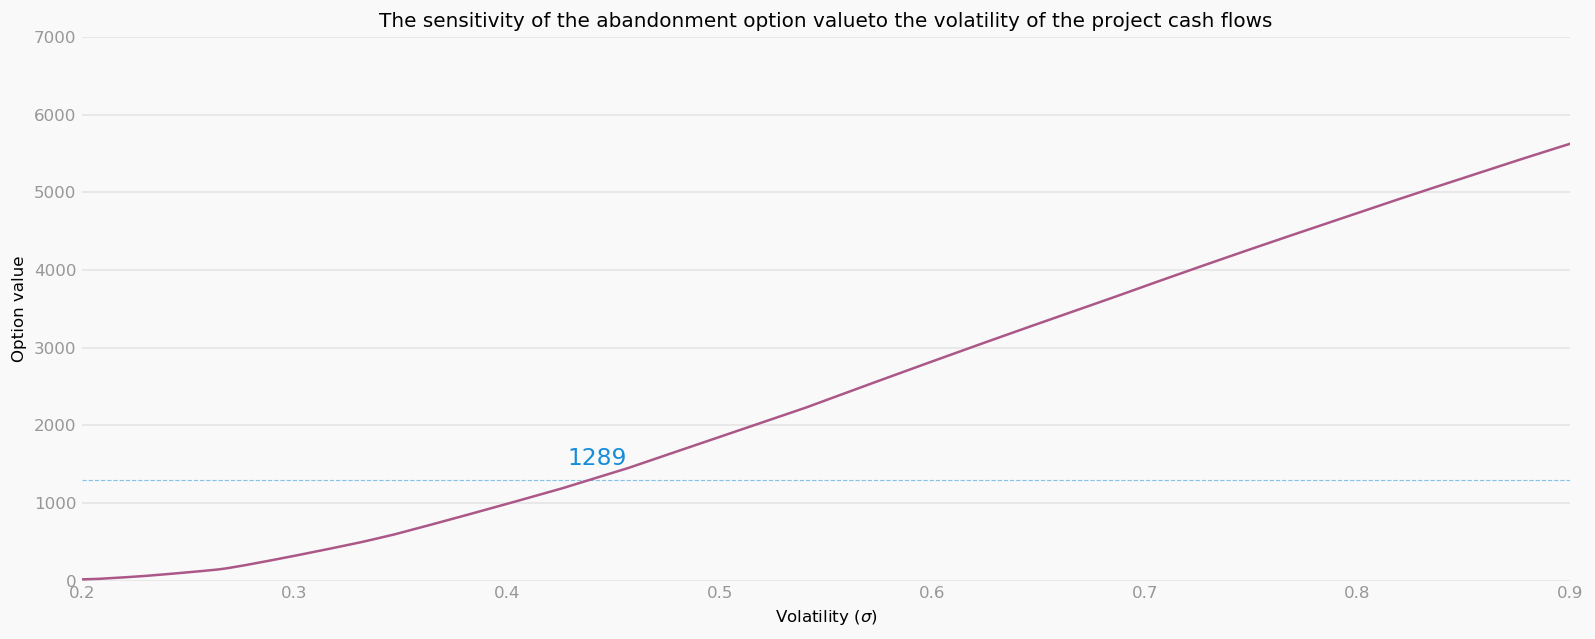

In [36]:
volatilities = np.arange(0.2, 1, 0.001)
values = [sim(σ=i, dr=dr, S0=PV0_d, K=K, t=t) for i in volatilities]

plt.plot(volatilities, values)
plt.ylim(bottom=0)
plt.xlim(right=0.9)
plt.hlines(option_value, xmin=volatilities.min(), xmax=volatilities.max(),
           color='#168dd9', linestyles='dashed',
           linewidth=0.7, alpha=0.5)
plt.xlabel('Volatility ($\sigma$)')
plt.annotate(str(int(option_value)), xy=(σ - 0.01, option_value + 200),
             color='#168dd9', size=14)
plt.ylabel('Option value')
plt.title('The sensitivity of the abandonment option value'
          'to the volatility of the project cash flows');


In [23]:
interact(sim, σ=(0.1, 1., 0.05), dr=(0.01, 1.00, 0.01),
         S0=fixed(PV0_d), K=fixed(K), t=(1,10));

interactive(children=(FloatSlider(value=0.55, description='σ', max=1.0, min=0.1, step=0.05), FloatSlider(value…

There are quite a few ways to improve a simple binomial option pricing model to get a better option value estimate, but one thing deserves special attention. To measure the volatility of our project cash flows, we had to discard about third of all trials, as the expression under the logarithm of present values was negative.

In [24]:
np.unique(np.isnan(log_PV), return_counts=True)

(array([False,  True]), array([678, 322], dtype=int64))

We can’t even pretend that the distribution of the project present value can be well approximated with the geometric Brownian motion. In the binomial lattices framework, this problem can be solved if we change the distributional assumption. For example, we can instead assume that the present value of the project cash flows follows an arithmetic Brownian motion.  
In the next exercise, we will investigate a conceptually different method to value real options, which naturally handles cases where the present value can be negative.